# **Machine Learning: Project Part 2**

---

**Author: Damien Farrell**

---


#### Step 1: Data Pre-processing
1. **Dataset Preparation**:
   - Work with provided uncompressed `.wav` files, which may contain large portions without any seal calls.
   - Create a dataset from annotated data using the provided Jupyter notebook.
<br><br>   
2. **Spectrogram Extraction**:
   - Extract spectrograms for each seal call, ensuring consistent size by determining the longest call (in time) and the broadest in frequency.
   - Save spectrograms as raw 2D arrays (not images) with metadata.
<br><br>
3. **Handling No-Call Data**:
   - Create "no-call" spectrograms from unannotated regions of recordings, ensuring they match the frequency region of call spectrograms.
<br><br> 

In [58]:
# Imports

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [59]:
# Global variables

FMIN = 20
FMAX = 1000
NFFT = 4096
NPERSEG = 2456
NOVERLAP = 1228
WINDOW = 'hann'
PROCESSED_DATA = 'processed_data.pkl'

folders = ['Guttural rupe', 'Moan', 'Rupes A and B']

Funcion to read all text files from a list of folders and organise their data into a DataFrame.

In [60]:
def read_text_files(folders: list) -> pd.DataFrame:
    data = []
    
    # Iterate through all folders
    for folder in folders:
        # Ensure the folder exists
        if not os.path.isdir(folder):
            print(f"Warning: {folder} is not a valid directory.")
            continue
        
        # Iterate through all files in the folder
        for filename in os.listdir(folder):
            if filename.endswith('.txt'):
                # Construct the file path
                file_path = os.path.join(folder, filename)
                try:
                    # Read the text file
                    df = pd.read_csv(file_path, sep='\t')

                    # Add metadata columns for file and folder names
                    df['file_name'] = os.path.splitext(filename)[0].replace('.Table.1.selections', '')
                    df['folder_name'] = os.path.basename(folder)
                    
                    # Append to the data list
                    data.append(df)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    
    # Combine all data into a single DataFrame
    combined_df = pd.concat(data, ignore_index=True) if data else pd.DataFrame()
    return combined_df

Funcion to read all WAV files from a list of folders and organise their data into a DataFrame.

In [61]:
def read_wav_files(folders: list) -> pd.DataFrame:
    data = []
    
    # Iterate through all folders
    for folder in folders:
        # Ensure the folder exists
        if not os.path.isdir(folder):
            print(f"Warning: {folder} is not a valid directory.")
            continue
        # Iterate through all files in the folder
        for filename in os.listdir(folder):
            if filename.endswith('.wav'):
                # Extract the base name and construct the WAV file path
                base_name = os.path.splitext(filename)[0]
                wav_file_path = os.path.join(folder, filename)
                try:
                    # Read the WAV file
                    sample_rate, samples = wavfile.read(wav_file_path)

                    # Append the results as a dictionary for each file
                    data.append({
                        "file_name": base_name,
                        "folder_name": os.path.basename(folder),
                        "sample_rate": sample_rate,
                        "samples": samples,
                    })
                except Exception as e:
                    print(f"Error reading {wav_file_path}: {e}")
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    return df

In [62]:
annot_df = read_text_files(folders)
wav_df = read_wav_files(folders)

In [63]:
annot_df.tail()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,file_name,folder_name
1891,50,Spectrogram 1,1,475.597473,475.816651,57.745,326.087,0.2192,268.342,-94.65,Rupe A,5713.210910070002,Rupes A and B
1892,51,Spectrogram 1,1,490.699030,490.883383,54.348,346.467,0.1844,292.119,-92.30,Rupe A,5713.210910070002,Rupes A and B
1893,52,Spectrogram 1,1,640.424359,640.501984,64.538,370.245,0.0776,305.707,-92.29,Rupe A,5713.210910070002,Rupes A and B
1894,53,Spectrogram 1,1,638.607007,638.661801,57.745,275.136,0.0548,217.391,-92.25,Rupe A,5713.210910070002,Rupes A and B
1895,54,Spectrogram 1,1,641.826191,641.878424,94.340,380.435,0.0522,286.095,-95.60,Rupe A,5713.210910070002,Rupes A and B


In [64]:
wav_df.tail()

,file_name,folder_name,sample_rate,samples
21,5713.210825190002,Rupes A and B,96000,"[-48, 330, -1410, 8307, 19232, 15949, 14278, 1..."
22,5713.210827200002,Rupes A and B,96000,"[-46, 329, -1421, 8479, 19284, 15909, 14328, 1..."
23,5713.210830050002,Rupes A and B,96000,"[-50, 343, -1461, 8531, 19594, 16164, 14530, 1..."
24,5713.210908180002,Rupes A and B,96000,"[-42, 313, -1380, 8646, 20005, 16930, 15186, 1..."
25,5713.210910070002,Rupes A and B,96000,"[-39, 315, -1431, 9217, 20196, 16928, 15442, 1..."


# Calculate the Spectrogram

In [65]:
# Function to get spectrogram and trim tiny values

def get_spectrogram(samples, sample_rate, 
                    nfft=NFFT, nperseg=NPERSEG, noverlap=NOVERLAP, window=WINDOW):

    frequencies, times, spectrogram = signal.spectrogram(samples, 
                                           fs=sample_rate,
                                           nfft=nfft,
                                           nperseg=nperseg,
                                           noverlap=noverlap,
                                           window=window)

    #Trim off all the tiny values so that log scale displays correctly
    spectrogram[spectrogram < 0.001] = 0.001
    
    #keep only frequencies of interest
    freq_slice = np.where((frequencies >= FMIN) & (frequencies <= FMAX))
    frequencies = frequencies[freq_slice]
    spectrogram = spectrogram[freq_slice, :][0]
    
    return frequencies, times, spectrogram

In [ ]:
# Check if the processed data file exists
if os.path.exists(PROCESSED_DATA) or ('spectrogram' in wav_df.columns):
    print(f"{PROCESSED_DATA} already exists. Skipping spectrogram processing")
else:
    # Initialise lists to store results
    freq_list = []
    times_list = []
    spectrogram_list = []

    # Loop through the DataFrame rows
    for i, row in tqdm(wav_df.iterrows(), total=len(wav_df), desc="Processing rows"):
        samples = row['samples']
        sample_rate = row['sample_rate']

        # Get spectrogram
        frequencies, times, spectrogram = get_spectrogram(samples, sample_rate)

        # Append results to the lists
        freq_list.append(frequencies)
        times_list.append(times)
        spectrogram_list.append(spectrogram)

    # Optionally, store the results back in the DataFrame
    wav_df['frequencies'] = freq_list
    wav_df['times'] = times_list
    wav_df['spectrogram'] = spectrogram_list

Processing rows: 100%|██████████| 26/26 [05:20<00:00, 12.34s/it]


In [67]:
wav_df.tail()

,file_name,folder_name,sample_rate,samples,frequencies,times,spectrogram
21,5713.210825190002,Rupes A and B,96000,"[-48, 330, -1410, 8307, 19232, 15949, 14278, 1...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14...","[0.012791666666666666, 0.025583333333333333, 0...","[[15413.003, 6513.0513, 3037.1604, 1609.5121, ..."
22,5713.210827200002,Rupes A and B,96000,"[-46, 329, -1421, 8479, 19284, 15909, 14328, 1...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14...","[0.012791666666666666, 0.025583333333333333, 0...","[[15388.988, 6500.1543, 3017.9536, 1607.9519, ..."
23,5713.210830050002,Rupes A and B,96000,"[-50, 343, -1461, 8531, 19594, 16164, 14530, 1...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14...","[0.012791666666666666, 0.025583333333333333, 0...","[[15223.219, 6482.534, 3033.506, 1604.0995, 94..."
24,5713.210908180002,Rupes A and B,96000,"[-42, 313, -1380, 8646, 20005, 16930, 15186, 1...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14...","[0.012791666666666666, 0.025583333333333333, 0...","[[14949.639, 6414.7363, 3016.4219, 1602.2367, ..."
25,5713.210910070002,Rupes A and B,96000,"[-39, 315, -1431, 9217, 20196, 16928, 15442, 1...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14...","[0.012791666666666666, 0.025583333333333333, 0...","[[14925.392, 6405.624, 3008.8594, 1603.7012, 9..."


Function that given a begin and end time, finds the closest indices in the spectrogram's time array

In [68]:
def time_to_spectrogram_indices(begin_t, end_t, times_array):
    """
    Given a begin and end time in seconds, find the closest indices in the spectrogram's time array.
    Returns (begin_idx, end_idx).
    """
    begin_idx = np.argmin(np.abs(times_array - begin_t))
    end_idx   = np.argmin(np.abs(times_array - end_t))
    
    # Ensure begin_idx < end_idx
    if begin_idx > end_idx:
        begin_idx, end_idx = end_idx, begin_idx
    
    return begin_idx, end_idx

In [69]:
# Define new columns for the spectrogram snippet, time, and frequency data
annot_df['snippet_spectrogram'] = None
annot_df['snippet_times'] = None
annot_df['snippet_frequencies'] = None

for idx, row in annot_df.iterrows():
    file_name = row['file_name']
    
    begin_time = row['Begin Time (s)']
    end_time   = row['End Time (s)']
    
    # Lookup the spectrogram data directly from wav_df
    spectrogram_row = wav_df[wav_df['file_name'] == file_name]

    # Extract necessary fields
    times_array       = spectrogram_row.iloc[0]['times']
    full_spectrogram  = spectrogram_row.iloc[0]['spectrogram']
    frequencies       = spectrogram_row.iloc[0]['frequencies']
    
    # Map annotation time to spectrogram time indices
    begin_idx, end_idx = time_to_spectrogram_indices(begin_time, end_time, times_array)
    
    # Slice the spectrogram in the time dimension
    snippet_spectrogram = full_spectrogram[:, begin_idx:end_idx+1]  # shape: (freq_bins, snippet_time_length)
    snippet_times = times_array[begin_idx:end_idx+1]    # Corresponding time bins
    snippet_frequencies = frequencies                  # Frequency bins remain unchanged
    
    # Update annot_df with the snippet, times, and frequencies
    annot_df.at[idx, 'snippet_spectrogram'] = snippet_spectrogram
    annot_df.at[idx, 'snippet_times'] = snippet_times
    annot_df.at[idx, 'snippet_frequencies'] = snippet_frequencies

In [70]:
annot_df.tail()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,file_name,folder_name,snippet_spectrogram,snippet_times,snippet_frequencies
1891,50,Spectrogram 1,1,475.597473,475.816651,57.745,326.087,0.2192,268.342,-94.65,Rupe A,5713.210910070002,Rupes A and B,"[[0.0062115975, 0.001, 0.001, 0.0022957232, 0....","[475.5941666666667, 475.60695833333335, 475.61...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
1892,51,Spectrogram 1,1,490.699030,490.883383,54.348,346.467,0.1844,292.119,-92.30,Rupe A,5713.210910070002,Rupes A and B,"[[0.0026007246, 0.008132841, 0.0029815964, 0.0...","[490.701125, 490.71391666666665, 490.726708333...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
1893,52,Spectrogram 1,1,640.424359,640.501984,64.538,370.245,0.0776,305.707,-92.29,Rupe A,5713.210910070002,Rupes A and B,"[[0.0015866946, 0.0094164135, 0.016591925, 0.0...","[640.4275833333334, 640.440375, 640.4531666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
1894,53,Spectrogram 1,1,638.607007,638.661801,57.745,275.136,0.0548,217.391,-92.25,Rupe A,5713.210910070002,Rupes A and B,"[[0.0011490879, 0.0048509277, 0.001, 0.0013756...","[638.6111666666667, 638.6239583333333, 638.636...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
1895,54,Spectrogram 1,1,641.826191,641.878424,94.340,380.435,0.0522,286.095,-95.60,Rupe A,5713.210910070002,Rupes A and B,"[[0.001761148, 0.009803783, 0.042642746, 0.026...","[641.821875, 641.8346666666666, 641.8474583333...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."


In [71]:
test = annot_df.iloc[1]['snippet_spectrogram']
print(type(test))
print(test.shape)
print(test)

<class 'numpy.ndarray'>
(42, 38)
[[4.2398296e+01 5.5681267e+01 8.3361542e+01 ... 1.2614148e+02
  1.3827675e+01 2.3410299e+00]
 [4.6510002e+01 5.1354435e+01 8.9442261e+01 ... 1.8058189e+02
  1.2389522e+01 2.5083859e+00]
 [1.0849077e+01 2.3562313e+01 3.6025940e+01 ... 6.1260056e+01
  1.7280804e+00 1.0468413e+00]
 ...
 [4.3305387e-03 8.4112911e-03 3.0931334e-03 ... 7.4063074e-03
  1.1549440e-03 1.0000000e-03]
 [1.6537016e-02 5.3482377e-03 1.2894402e-03 ... 1.0000000e-03
  4.5062155e-03 1.8679473e-03]
 [2.4293978e-02 4.8979130e-03 1.0000000e-03 ... 3.9182119e-03
  1.1836254e-02 3.3423279e-03]]


In [72]:
# Check if the file exists before saving
if not os.path.exists(PROCESSED_DATA):
    annot_df.to_pickle(PROCESSED_DATA)
    print(f"DataFrame saved to {PROCESSED_DATA}")
else:
    print(f"File {PROCESSED_DATA} already exists.")

DataFrame saved to processed_data.pkl


In [73]:
def overlay_annotations(ax, df, annotation_colors):
    #Track labels to ensure they are added only once in the legend
    added_labels = set()

    for _, row in df.iterrows():
        start_time = row['Begin Time (s)']
        end_time = row['End Time (s)']
        low_freq = row['Low Freq (Hz)']
        high_freq = row['High Freq (Hz)']
        annotation = row['Annotation']

        #Skip if the annotation is not in the defined colors
        if annotation not in annotation_colors:
            continue

        #Draw rectangles
        ax.add_patch(
            plt.Rectangle(
                (start_time, low_freq),  #Bottom Left corner
                end_time - start_time,  #Width (time)
                high_freq - low_freq,  #Height (frequency)
                edgecolor=annotation_colors[annotation],
                facecolor='none',
                linewidth=2,
                label=annotation if annotation not in added_labels else None  #Add label once
            )
        )
        added_labels.add(annotation)  #Mark label as added

    ax.legend(loc='upper right')     #Add legend

In [74]:
def update_colormap(event):
    #Get current view limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    #Find indices corresponding to the current view limits
    x_indices = np.where((times >= xlim[0]) & (times <= xlim[1]))[0]
    y_indices = np.where((frequencies >= ylim[0]) & (frequencies <= ylim[1]))[0]

    #Handle cases where no data is visible
    if len(x_indices) == 0 or len(y_indices) == 0:
        return

    #Extract the visible data
    data_visible = spectrogram[np.ix_(y_indices, x_indices)]
    #data_visible = np.log(spectrogram)[np.ix_(y_indices, x_indices)]

    #Compute new color limits
    vmin = np.nanmin(data_visible)
    vmax = np.nanmax(data_visible)

    #Update the color limits of the pcolormesh
    pc.set_clim(vmin=vmin, vmax=vmax)
    
    #Update the colorbar to reflect the new color limits
    cbar.update_normal(pc)

    #Redraw the figure
    plt.draw()

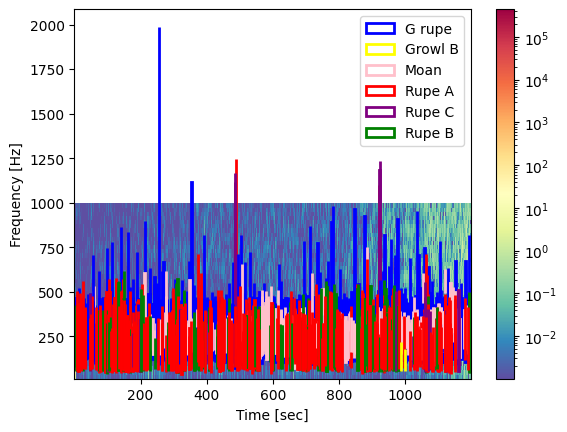

In [75]:
#Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C" : "purple",
    "Moan": "pink",
    "G rupe" : "blue"
}

pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
#pc = plt.pcolormesh(times, frequencies, np.log(spectrogram))
cbar = plt.colorbar(pc)
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#Get the current axes
ax = plt.gca()
overlay_annotations(ax, annot_df, annotation_colors)

#Connect the update function to the axes limit change events
ax.callbacks.connect('xlim_changed', update_colormap)
ax.callbacks.connect('ylim_changed', update_colormap)

plt.show()

(25, 469)


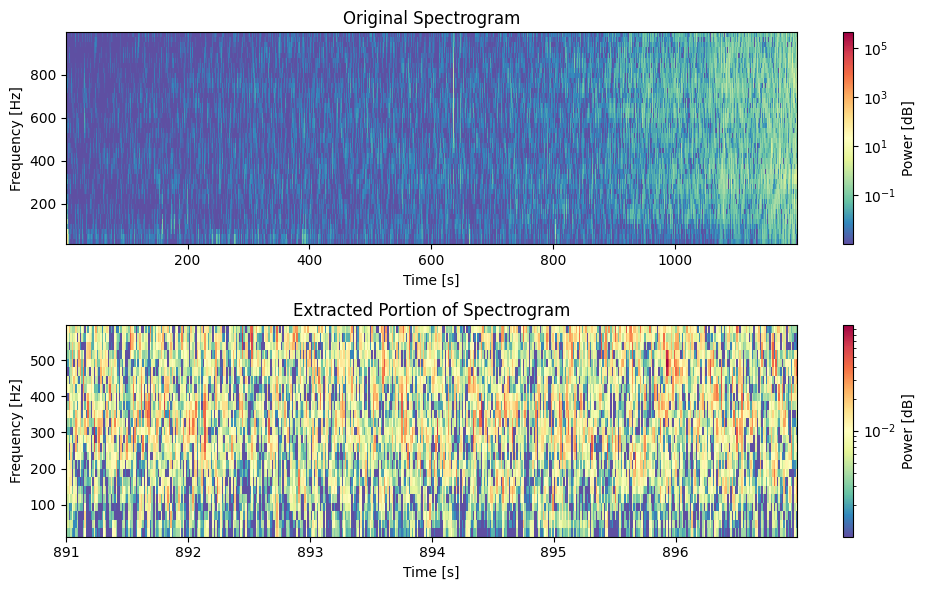

In [76]:
#Define time and frequency limits
time_start, time_end = 891, 897  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
time_indices = np.where((times >= time_start) & (times <= time_end))[0]

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print(spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()

Spectrogram size:  (25, 55)


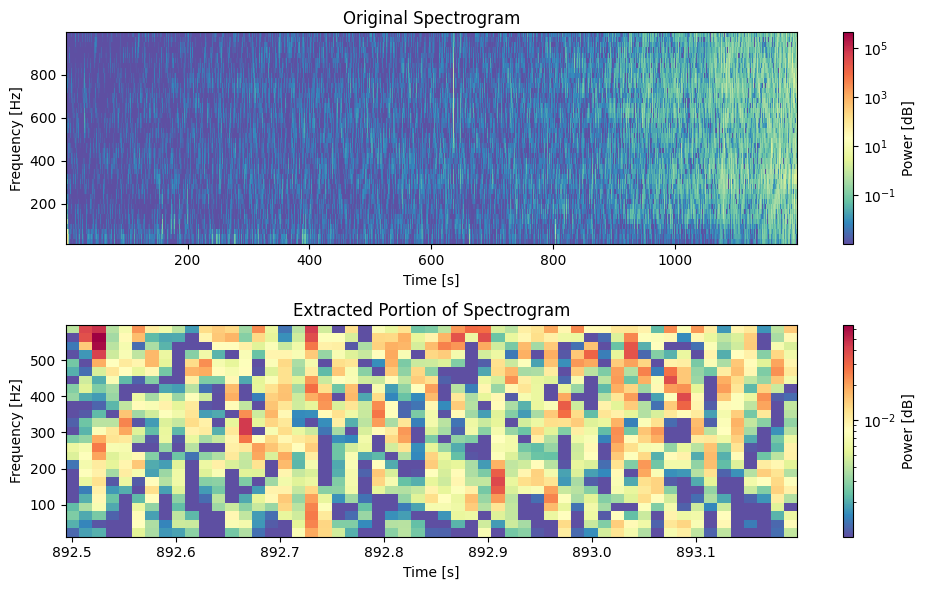

In [77]:
#Define time and frequency limits
time_start, time_end = 892.5, 893.2  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
time_indices = np.where((times >= time_start) & (times <= time_end))[0]

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print("Spectrogram size: ", spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()